In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
D003_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D003_data.csv')
D003_df = pd.DataFrame(D003_df)
D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
D003_df.index = D003_df['time']
D003_df = D003_df.drop(['time'],axis = 1)

In [3]:
def df_to_X_y(df,hoursToPredict, windowSize):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + windowSize)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+windowSize]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + windowSize ][0]
                y.append(label)
        return np.array(X), np.array(y)

In [4]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = df_to_X_y(D003_df,hoursToPredict,windowSize)

    return X1, y1

In [5]:
plt.style.use('seaborn')

In [6]:
def Trainer(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [7]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model = load_model(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        windowSize += 1

In [8]:
%%time

Trainer(1,6,9)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 10ms/step - loss: 807.8854 - mean_absolute_error: 28.1715 - val_loss: 549.0300 - val_mean_absolute_error: 23.2934
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 399.0266 - mean_absolute_error: 19.5012 - val_loss: 196.4539 - val_mean_absolute_error: 13.7735
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 123.8393 - mean_absolute_error: 10.3514 - val_loss: 34.9916 - val_mean_absolute_error: 5.3104
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 10ms/step - loss: 31.3736 - mean_absolute_error: 4.7055 - val_loss: 8.9496 - val_mean_absolute_error: 2.367239 - mean_absolute_error: 5.09 - ETA: 0s - l
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 11.7636 - mean_absolute_error: 2.7036 - val_loss: 4.6851 - val_mean_absolute_error: 1.7633
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 8.2533 - mean_absolute_error: 2.2592 - val_loss: 4.8169 - val_mean_absolute_error: 1.8069
Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 7.3731 - mean_absolute_error: 2.1319 - val_loss: 4.8534 - val_mean_absolute_error: 1.8062
Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 6.5613 - mean_absolute_error: 1.9961 - val_loss: 4.7809 - val_mean_absolute_error: 1.7934
Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 5.5670 - mean_absolute_error: 1.8315 - val_loss: 4.0932 - val_mean_absolute_error: 1.6575A: 2s 
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 4.5868 - mean_absolute_error: 1.6439 - val_loss: 3.4067 - val_mean_absolute_error: 1.50866 - mean_absolute_er
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 3.4801 - mean_absolute_error: 1.4099 - val_loss: 2.1294 - val_mean_absolute_error: 1.1649
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 2.5330 - mean_absolute_error: 1.1826 - val_loss: 1.7203 - val_mean_absolute_error: 1.0341
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 7ms/step - loss: 1.8347 - mean_absolute_error: 0.9763 - val_loss: 1.0721 - val_mean_absolute_error: 0.7946
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 1.3082 - mean_absolute_error: 0.8045 - val_loss: 0.8181 - val_mean_absolute_error: 0.6966
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0134 - mean_absolute_error: 0.6935 - val_loss: 0.5731 - val_mean_absolute_error: 0.5616
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 2s 6ms/step - loss: 0.8065 - mean_absolute_error: 0.6179 - val_loss: 0.4627 - val_mean_absolute_error: 0.5041
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 8ms/step - loss: 0.6631 - mean_absolute_error: 0.5641 - val_loss: 0.4401 - val_mean_absolute_error: 0.4758
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 0.5657 - mean_absolute_error: 0.5212 - val_loss: 0.4291 - val_mean_absolute_error: 0.4664
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 5s 13ms/step - loss: 0.4800 - mean_absolute_error: 0.4782 - val_loss: 0.3288 - val_mean_absolute_error: 0.4158
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 7ms/step - loss: 0.4380 - mean_absolute_error: 0.4546 - val_loss: 0.3522 - val_mean_absolute_error: 0.4512
Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 0.4100 - mean_absolute_error: 0.4359 - val_loss: 0.3058 - val_mean_absolute_error: 0.4161
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 7ms/step - loss: 0.3919 - mean_absolute_error: 0.4234 - val_loss: 0.2952 - val_mean_absolute_error: 0.3983
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 7ms/step - loss: 0.3753 - mean_absolute_error: 0.4128 - val_loss: 0.2858 - val_mean_absolute_error: 0.3866
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 8ms/step - loss: 0.3682 - mean_absolute_error: 0.4091 - val_loss: 0.2699 - val_mean_absolute_error: 0.3820
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 2s 7ms/step - loss: 0.3573 - mean_absolute_error: 0.4031 - val_loss: 0.2784 - val_mean_absolute_error: 0.3858

-----------------------------------------------------------------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 11ms/step - loss: 786.1948 - mean_absolute_error

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 468.4016 - mean_absolute_error: 21.3011 - val_loss: 266.6021 - val_mean_absolute_error: 16.1580
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 216.9003 - mean_absolute_error: 14.2814 - val_loss: 120.1312 - val_mean_absolute_error: 10.6388
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 7ms/step - loss: 106.1461 - mean_absolute_error: 9.6744 - val_loss: 45.9690 - val_mean_absolute_error: 6.2240
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 42.2080 - mean_absolute_error: 5.6516 - val_loss: 13.4822 - val_mean_absolute_error: 2.8936
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 18.2263 - mean_absolute_error: 3.4144 - val_loss: 7.5218 - val_mean_absolute_error: 2.2537
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 11.9165 - mean_absolute_error: 2.7190 - val_loss: 5.4665 - val_mean_absolute_error: 1.9282
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 9.7770 - mean_absolute_error: 2.4717 - val_loss: 5.8427 - val_mean_absolute_error: 2.0492
Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 9.0124 - mean_absolute_error: 2.3691 - val_loss: 4.5195 - val_mean_absolute_error: 1.7493
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 8.3227 - mean_absolute_error: 2.2594 - val_loss: 4.6176 - val_mean_absolute_error: 1.7283
Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 7.8633 - mean_absolute_error: 2.1929 - val_loss: 4.4223 - val_mean_absolute_error: 1.6621
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 7ms/step - loss: 7.4200 - mean_absolute_error: 2.1251 - val_loss: 3.8982 - val_mean_absolute_error: 1.5530
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 7ms/step - loss: 6.6177 - mean_absolute_error: 1.9996 - val_loss: 3.3825 - val_mean_absolute_error: 1.4525
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 5.8018 - mean_absolute_error: 1.8630 - val_loss: 3.0531 - val_mean_absolute_error: 1.3673
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 4.6026 - mean_absolute_error: 1.6427 - val_loss: 2.3428 - val_mean_absolute_error: 1.1878
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 7ms/step - loss: 3.4031 - mean_absolute_error: 1.3851 - val_loss: 2.0026 - val_mean_absolute_error: 1.0834
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 8ms/step - loss: 2.5964 - mean_absolute_error: 1.1819 - val_loss: 1.4030 - val_mean_absolute_error: 0.8969
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 8ms/step - loss: 1.8783 - mean_absolute_error: 0.9688 - val_loss: 0.9924 - val_mean_absolute_error: 0.7323
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 4s 10ms/step - loss: 1.4002 - mean_absolute_error: 0.8170 - val_loss: 0.7988 - val_mean_absolute_error: 0.6221
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.1357 - mean_absolute_error: 0.7325 - val_loss: 0.7377 - val_mean_absolute_error: 0.6055
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9526 - mean_absolute_error: 0.6679 - val_loss: 0.6413 - val_mean_absolute_error: 0.5653
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.8179 - mean_absolute_error: 0.6209 - val_loss: 0.6326 - val_mean_absolute_error: 0.5532
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7210 - mean_absolute_error: 0.5839 - val_loss: 0.5420 - val_mean_absolute_error: 0.5309
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.5980 - mean_absolute_error: 0.5362 - val_loss: 0.5324 - val_mean_absolute_error: 0.5074
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 7ms/step - loss: 0.5483 - mean_absolute_error: 0.5121 - val_loss: 0.5101 - val_mean_absolute_error: 0.5087
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 10ms/step - loss: 816.4381 - mean_absolute_error: 28.3170 - val_loss: 543.7266 - val_mean_absolute_error: 23.2207 - me
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 319.0271 - mean_absolute_error: 17.2241 - val_loss: 123.0274 - val_mean_absolute_error: 10.7693
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 89.5418 - mean_absolute_error: 8.6943 - val_loss: 24.6238 - val_mean_absolute_error: 4.2247
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 10ms/step - loss: 22.7242 - mean_absolute_error: 3.8725 - val_loss: 6.9176 - val_mean_absolute_error: 2.0975
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 11.5284 - mean_absolute_error: 2.6758 - val_loss: 6.2877 - val_mean_absolute_error: 2.1205
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 9.6796 - mean_absolute_error: 2.4690 - val_loss: 5.1407 - val_mean_absolute_error: 1.8493
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 8.1534 - mean_absolute_error: 2.2383 - val_loss: 4.6032 - val_mean_absolute_error: 1.7416
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 7.4852 - mean_absolute_error: 2.1342 - val_loss: 3.9570 - val_mean_absolute_error: 1.5689
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 4s 10ms/step - loss: 6.4207 - mean_absolute_error: 1.9595 - val_loss: 3.5892 - val_mean_absolute_error: 1.4729
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 5.7837 - mean_absolute_error: 1.8549 - val_loss: 3.7059 - val_mean_absolute_error: 1.4960
Epoch 11/25
376/376 [==============================] - 4s 11ms/step - loss: 4.8239 - mean_absolute_error: 1.6857 - val_loss: 3.0586 - val_mean_absolute_error: 1.3599
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 3.7148 - mean_absolute_error: 1.4628 - val_loss: 2.6963 - val_mean_absolute_error: 1.2851
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 2.6650 - mean_absolute_error: 1.2292 - val_loss: 1.9062 - val_mean_absolute_error: 1.0510 loss: 2.8551 - mean_absolu
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 1.5828 - mean_absolute_error: 0.9314 - val_loss: 1.2008 - val_mean_absolute_error: 0.8168
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 1.0092 - mean_absolute_error: 0.7236 - val_loss: 0.8585 - val_mean_absolute_error: 0.6759
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 0.8021 - mean_absolute_error: 0.6352 - val_loss: 0.6831 - val_mean_absolute_error: 0.5629
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7038 - mean_absolute_error: 0.5884 - val_loss: 0.6360 - val_mean_absolute_error: 0.5461
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 9ms/step - loss: 0.6456 - mean_absolute_error: 0.5638 - val_loss: 0.5167 - val_mean_absolute_error: 0.5184
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 0.6013 - mean_absolute_error: 0.5455 - val_loss: 0.5387 - val_mean_absolute_error: 0.5053
Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5648 - mean_absolute_error: 0.5265 - val_loss: 0.5050 - val_mean_absolute_error: 0.4838
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5398 - mean_absolute_error: 0.5165 - val_loss: 0.5662 - val_mean_absolute_error: 0.5022
Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.5094 - mean_absolute_error: 0.5006 - val_loss: 0.3878 - val_mean_absolute_error: 0.4680
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 8ms/step - loss: 0.4813 - mean_absolute_error: 0.4855 - val_loss: 0.3870 - val_mean_absolute_error: 0.4488
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.4593 - mean_absolute_error: 0.4714 - val_loss: 0.3852 - val_mean_absolute_error: 0.4494
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 8ms/step - loss: 0.4487 - mean_absolute_error: 0.4661 - val_loss: 0.3744 - val_mean_absolute_error: 0.4681
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 8s 15ms/step - loss: 811.9035 - mean_absolute_error: 28.2752 - val_loss: 583.9981 - val_mean_absolute_error: 24.0567
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 9ms/step - loss: 473.0316 - mean_absolute_error: 21.3876 - val_loss: 274.5463 - val_mean_absolute_error: 16.3763
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 11ms/step - loss: 222.2619 - mean_absolute_error: 14.4150 - val_loss: 101.3015 - val_mean_absolute_error: 9.7315
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 83.9503 - mean_absolute_error: 8.4489 - val_loss: 31.7811 - val_mean_absolute_error: 4.9453
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 33.0637 - mean_absolute_error: 4.8820 - val_loss: 11.2260 - val_mean_absolute_error: 2.6340
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 15.5852 - mean_absolute_error: 3.1262 - val_loss: 6.6220 - val_mean_absolute_error: 2.1023
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 10.4793 - mean_absolute_error: 2.5535 - val_loss: 5.0944 - val_mean_absolute_error: 1.8373
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 10ms/step - loss: 8.6785 - mean_absolute_error: 2.3255 - val_loss: 4.7528 - val_mean_absolute_error: 1.7719
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 7.9308 - mean_absolute_error: 2.2114 - val_loss: 4.1880 - val_mean_absolute_error: 1.6075
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 10ms/step - loss: 6.6776 - mean_absolute_error: 2.0056 - val_loss: 3.1950 - val_mean_absolute_error: 1.3876
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 5s 14ms/step - loss: 5.7622 - mean_absolute_error: 1.8406 - val_loss: 2.9707 - val_mean_absolute_error: 1.3420
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 5.1645 - mean_absolute_error: 1.7318 - val_loss: 2.6800 - val_mean_absolute_error: 1.2667
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 4.4651 - mean_absolute_error: 1.5938 - val_loss: 2.4414 - val_mean_absolute_error: 1.2003
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 5s 12ms/step - loss: 3.7191 - mean_absolute_error: 1.4397 - val_loss: 2.0831 - val_mean_absolute_error: 1.0971
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 3.1689 - mean_absolute_error: 1.3189 - val_loss: 1.8270 - val_mean_absolute_error: 1.0307
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 9ms/step - loss: 2.5841 - mean_absolute_error: 1.1889 - val_loss: 1.4279 - val_mean_absolute_error: 0.8965
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 2.0186 - mean_absolute_error: 1.0526 - val_loss: 1.1963 - val_mean_absolute_error: 0.8217
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 9ms/step - loss: 1.6537 - mean_absolute_error: 0.9492 - val_loss: 1.1292 - val_mean_absolute_error: 0.8125
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 1.4036 - mean_absolute_error: 0.8672 - val_loss: 1.1709 - val_mean_absolute_error: 0.8337
Epoch 20/25
376/376 [==============================] - 4s 9ms/step - loss: 1.0216 - mean_absolute_error: 0.7190 - val_loss: 0.6846 - val_mean_absolute_error: 0.6081
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 11ms/step - loss: 0.7986 - mean_absolute_error: 0.6260 - val_loss: 0.6121 - val_mean_absolute_error: 0.5733 - loss: 0.8114 - mean_absolute_err
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 0.6551 - mean_absolute_error: 0.5628 - val_loss: 0.4950 - val_mean_absolute_error: 0.5121
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 4s 9ms/step - loss: 0.5719 - mean_absolute_error: 0.5187 - val_loss: 0.4211 - val_mean_absolute_error: 0.4634
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.5037 - mean_absolute_error: 0.4786 - val_loss: 0.3839 - val_mean_absolute_error: 0.4358
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 9ms/step - loss: 0.4474 - mean_absolute_error: 0.4485 - val_loss: 0.4630 - val_mean_absolute_error: 0.4787

-----------------------------------------------------------------------------------------------------------

CPU times: total: 45min 12s
Wall time: 19min 52s


In [9]:
%%time

modelsEvaluator(1,6,9)

(12010, 6, 5) (12010,) (4004, 6, 5) (4004,) (4004, 6, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.3628 - mean_absolute_error: 0.4133A: 0s - loss: 0.3448 - mean_absolute_error: 0.
(12009, 7, 5) (12009,) (4004, 7, 5) (4004,) (4004, 7, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.5092 - mean_absolute_error: 0.5206
(12009, 8, 5) (12009,) (4003, 8, 5) (4003,) (4004, 8, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.4153 - mean_absolute_error: 0.4775
(12009, 9, 5) (12009,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 1H_Forecast/1H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 0.4420 - mean_absolute_error: 0.4661
CPU times: total: 1min
Wall time: 41 s


126/126 [==============================] - 2s 3ms/step - loss: 0.3456 - mean_absolute_error: 0.4121


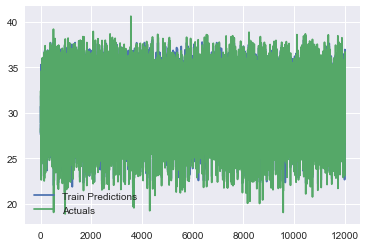

In [20]:
model = load_model('1H_Forecast/1H_ForecastModel_6_SizeWindow/')

X, y = DataHandler(1,6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 2 hours forecast

In [10]:
%%time

Trainer(2,6,9)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 10ms/step - loss: 832.8395 - mean_absolute_error: 28.6618 - val_loss: 641.0337 - val_mean_absolute_error: 25.2142
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 469.9245 - mean_absolute_error: 21.1923 - val_loss: 202.4823 - val_mean_absolute_error: 14.0142
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 131.2101 - mean_absolute_error: 10.7210 - val_loss: 40.3612 - val_mean_absolute_error: 5.7599
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 7ms/step - loss: 32.7636 - mean_absolute_error: 4.8067 - val_loss: 9.0700 - val_mean_absolute_error: 2.3663
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 13.2265 - mean_absolute_error: 2.8733 - val_loss: 7.2312 - val_mean_absolute_error: 2.2437
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 4s 10ms/step - loss: 10.4957 - mean_absolute_error: 2.5882 - val_loss: 6.6593 - val_mean_absolute_error: 2.1652
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 2s 7ms/step - loss: 9.0217 - mean_absolute_error: 2.3894 - val_loss: 5.8992 - val_mean_absolute_error: 2.0237
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 8.4277 - mean_absolute_error: 2.2969 - val_loss: 5.5109 - val_mean_absolute_error: 1.9264
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 8.1387 - mean_absolute_error: 2.2502 - val_loss: 5.1097 - val_mean_absolute_error: 1.7918
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 7.8399 - mean_absolute_error: 2.2007 - val_loss: 4.8545 - val_mean_absolute_error: 1.7376
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 7.7062 - mean_absolute_error: 2.1808 - val_loss: 4.7134 - val_mean_absolute_error: 1.7155A: 0s - loss: 7.7181 - mean_absolute_error: 2.1 - ETA: 0s - loss: 7.7175 - mean_absolute_e - ETA: 0s - loss: 7.6913 - mean_absolute_error: 2.
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 7ms/step - loss: 6.8432 - mean_absolute_error: 2.0498 - val_loss: 3.9494 - val_mean_absolute_error: 1.5266: 1s - loss: 
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 5.5915 - mean_absolute_error: 1.8442 - val_loss: 3.2602 - val_mean_absolute_error: 1.3819
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 7ms/step - loss: 4.3770 - mean_absolute_error: 1.6142 - val_loss: 2.3944 - val_mean_absolute_error: 1.1659
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 7ms/step - loss: 3.1939 - mean_absolute_error: 1.3564 - val_loss: 2.0575 - val_mean_absolute_error: 1.0635
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 7ms/step - loss: 2.2295 - mean_absolute_error: 1.1122 - val_loss: 1.4045 - val_mean_absolute_error: 0.8552
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 7ms/step - loss: 1.6059 - mean_absolute_error: 0.9315 - val_loss: 0.9370 - val_mean_absolute_error: 0.7016
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 1.1886 - mean_absolute_error: 0.7815 - val_loss: 0.7554 - val_mean_absolute_error: 0.6469
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 0.8962 - mean_absolute_error: 0.6639 - val_loss: 0.7378 - val_mean_absolute_error: 0.6326
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7909 - mean_absolute_error: 0.6220 - val_loss: 0.7092 - val_mean_absolute_error: 0.6523
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7238 - mean_absolute_error: 0.5905 - val_loss: 0.6819 - val_mean_absolute_error: 0.5980
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 2s 6ms/step - loss: 0.6616 - mean_absolute_error: 0.5617 - val_loss: 0.5874 - val_mean_absolute_error: 0.5557
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 2s 6ms/step - loss: 0.6041 - mean_absolute_error: 0.5325 - val_loss: 0.5902 - val_mean_absolute_error: 0.5558
Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.5709 - mean_absolute_error: 0.5156 - val_loss: 0.5018 - val_mean_absolute_error: 0.5293
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5482 - mean_absolute_error: 0.5042 - val_loss: 0.4859 - val_mean_absolute_error: 0.5038
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 8s 12ms/step - loss: 852.0953 - mean_absolute_error: 28.9825 - val_loss: 671.6094 - val_mean_absolute_error: 25.7900
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 619.5264 - mean_absolute_error: 24.6382 - val_loss: 423.5652 - val_mean_absolute_error: 20.4427
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 5s 12ms/step - loss: 359.1625 - mean_absolute_error: 18.5913 - val_loss: 212.8025 - val_mean_absolute_error: 14.3429
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 182.5784 - mean_absolute_error: 12.9957 - val_loss: 91.0426 - val_mean_absolute_error: 9.1467
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 11ms/step - loss: 81.0896 - mean_absolute_error: 8.2833 - val_loss: 32.1603 - val_mean_absolute_error: 4.9752
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 31.8158 - mean_absolute_error: 4.7655 - val_loss: 10.1411 - val_mean_absolute_error: 2.5125
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 14.5533 - mean_absolute_error: 3.0096 - val_loss: 5.9815 - val_mean_absolute_error: 2.0178
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 12ms/step - loss: 9.9098 - mean_absolute_error: 2.4946 - val_loss: 5.9733 - val_mean_absolute_error: 2.0799
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 9.0296 - mean_absolute_error: 2.3834 - val_loss: 5.2445 - val_mean_absolute_error: 1.9159
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 5s 14ms/step - loss: 8.2453 - mean_absolute_error: 2.2555 - val_loss: 4.7353 - val_mean_absolute_error: 1.7877
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 8ms/step - loss: 7.8537 - mean_absolute_error: 2.1908 - val_loss: 4.6030 - val_mean_absolute_error: 1.7150
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 4s 10ms/step - loss: 7.4119 - mean_absolute_error: 2.1195 - val_loss: 4.5794 - val_mean_absolute_error: 1.6816
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 6s 16ms/step - loss: 7.0977 - mean_absolute_error: 2.0694 - val_loss: 4.7310 - val_mean_absolute_error: 1.7482
Epoch 14/25
376/376 [==============================] - 5s 14ms/step - loss: 6.5685 - mean_absolute_error: 1.9881 - val_loss: 3.5138 - val_mean_absolute_error: 1.4373
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 10ms/step - loss: 5.1215 - mean_absolute_error: 1.7638 - val_loss: 2.5358 - val_mean_absolute_error: 1.2428
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 5s 12ms/step - loss: 4.1994 - mean_absolute_error: 1.5820 - val_loss: 2.2255 - val_mean_absolute_error: 1.1266
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 5s 13ms/step - loss: 3.2514 - mean_absolute_error: 1.3735 - val_loss: 1.7654 - val_mean_absolute_error: 1.0084
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 11ms/step - loss: 2.2120 - mean_absolute_error: 1.1179 - val_loss: 1.2710 - val_mean_absolute_error: 0.8351
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.3173 - mean_absolute_error: 0.8238 - val_loss: 0.9858 - val_mean_absolute_error: 0.7303
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9754 - mean_absolute_error: 0.6903 - val_loss: 1.0277 - val_mean_absolute_error: 0.7281
Epoch 21/25
376/376 [==============================] - 3s 8ms/step - loss: 0.8313 - mean_absolute_error: 0.6366 - val_loss: 0.7525 - val_mean_absolute_error: 0.6321
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7196 - mean_absolute_error: 0.5902 - val_loss: 0.6662 - val_mean_absolute_error: 0.5835
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 8ms/step - loss: 0.6463 - mean_absolute_error: 0.5578 - val_loss: 0.7295 - val_mean_absolute_error: 0.5846
Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.6115 - mean_absolute_error: 0.5400 - val_loss: 0.6519 - val_mean_absolute_error: 0.5570
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 8ms/step - loss: 0.5762 - mean_absolute_error: 0.5224 - val_loss: 0.5897 - val_mean_absolute_error: 0.5738
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 8s 11ms/step - loss: 847.6127 - mean_absolute_error: 28.8945 - val_loss: 589.7576 - val_mean_absolute_error: 24.1828
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 435.0454 - mean_absolute_error: 20.4473 - val_loss: 228.8753 - val_mean_absolute_error: 14.9323
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 10ms/step - loss: 184.5480 - mean_absolute_error: 13.0931 - val_loss: 92.7981 - val_mean_absolute_error: 9.2744
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 81.1030 - mean_absolute_error: 8.3039 - val_loss: 33.0056 - val_mean_absolute_error: 5.0637
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 34.4658 - mean_absolute_error: 5.0199 - val_loss: 12.0282 - val_mean_absolute_error: 2.7189
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 17.0636 - mean_absolute_error: 3.2912 - val_loss: 7.6195 - val_mean_absolute_error: 2.2718
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 9ms/step - loss: 12.2450 - mean_absolute_error: 2.7780 - val_loss: 7.9730 - val_mean_absolute_error: 2.3801
Epoch 8/25
376/376 [==============================] - 4s 11ms/step - loss: 9.9546 - mean_absolute_error: 2.4821 - val_loss: 5.0802 - val_mean_absolute_error: 1.7845
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 8.2460 - mean_absolute_error: 2.2533 - val_loss: 4.4206 - val_mean_absolute_error: 1.6236
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 11ms/step - loss: 7.2130 - mean_absolute_error: 2.0848 - val_loss: 3.7428 - val_mean_absolute_error: 1.4812
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 9ms/step - loss: 6.0431 - mean_absolute_error: 1.8888 - val_loss: 3.0759 - val_mean_absolute_error: 1.3102
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 5s 12ms/step - loss: 4.7602 - mean_absolute_error: 1.6597 - val_loss: 3.1263 - val_mean_absolute_error: 1.2934
Epoch 13/25
376/376 [==============================] - 7s 18ms/step - loss: 3.8408 - mean_absolute_error: 1.4873 - val_loss: 2.8642 - val_mean_absolute_error: 1.2356
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 12ms/step - loss: 3.1200 - mean_absolute_error: 1.3281 - val_loss: 2.0225 - val_mean_absolute_error: 1.0469
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 5s 12ms/step - loss: 2.4555 - mean_absolute_error: 1.1602 - val_loss: 1.9503 - val_mean_absolute_error: 1.0020
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 9ms/step - loss: 1.9288 - mean_absolute_error: 1.0278 - val_loss: 1.7053 - val_mean_absolute_error: 0.9379
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 10ms/step - loss: 1.5894 - mean_absolute_error: 0.9336 - val_loss: 1.8151 - val_mean_absolute_error: 0.9224
Epoch 18/25
376/376 [==============================] - 4s 11ms/step - loss: 1.3950 - mean_absolute_error: 0.8770 - val_loss: 1.5372 - val_mean_absolute_error: 0.8934
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.2722 - mean_absolute_error: 0.8326 - val_loss: 1.0777 - val_mean_absolute_error: 0.7845bsolute_error: 
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 5s 12ms/step - loss: 1.1502 - mean_absolute_error: 0.7911 - val_loss: 1.0108 - val_mean_absolute_error: 0.7462
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 1.0465 - mean_absolute_error: 0.7454 - val_loss: 0.9723 - val_mean_absolute_error: 0.7474
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 0.9604 - mean_absolute_error: 0.7085 - val_loss: 0.7767 - val_mean_absolute_error: 0.6446
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 5s 12ms/step - loss: 0.8319 - mean_absolute_error: 0.6542 - val_loss: 0.7559 - val_mean_absolute_error: 0.6358
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7850 - mean_absolute_error: 0.6334 - val_loss: 0.7645 - val_mean_absolute_error: 0.6346
Epoch 25/25
376/376 [==============================] - 3s 8ms/step - loss: 0.7425 - mean_absolute_error: 0.6153 - val_loss: 0.6620 - val_mean_absolute_error: 0.5996
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 10ms/step - loss: 769.9998 - mean_absolute_error: 27.4563 - val_loss: 476.2981 - val_mean_absolute_error: 21.7249
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 9ms/step - loss: 312.9759 - mean_absolute_error: 17.1124 - val_loss: 103.8032 - val_mean_absolute_error: 9.9332
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 10ms/step - loss: 61.3691 - mean_absolute_error: 6.9498 - val_loss: 13.6493 - val_mean_absolute_error: 2.9268
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 12ms/step - loss: 15.6270 - mean_absolute_error: 3.1274 - val_loss: 6.6035 - val_mean_absolute_error: 2.0646
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 9ms/step - loss: 10.0158 - mean_absolute_error: 2.4966 - val_loss: 5.4469 - val_mean_absolute_error: 1.9204
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 8.3231 - mean_absolute_error: 2.2662 - val_loss: 4.8901 - val_mean_absolute_error: 1.7790
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 7.5263 - mean_absolute_error: 2.1460 - val_loss: 4.2914 - val_mean_absolute_error: 1.5968
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 10ms/step - loss: 6.6689 - mean_absolute_error: 2.0029 - val_loss: 4.0958 - val_mean_absolute_error: 1.5493
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 6.1857 - mean_absolute_error: 1.9165 - val_loss: 3.7941 - val_mean_absolute_error: 1.4551
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 9ms/step - loss: 5.5216 - mean_absolute_error: 1.7988 - val_loss: 3.1301 - val_mean_absolute_error: 1.2904
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 9ms/step - loss: 4.5786 - mean_absolute_error: 1.6246 - val_loss: 2.5866 - val_mean_absolute_error: 1.1462
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 3.4847 - mean_absolute_error: 1.4019 - val_loss: 2.1281 - val_mean_absolute_error: 1.0605
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 2.7694 - mean_absolute_error: 1.2442 - val_loss: 1.8156 - val_mean_absolute_error: 0.9692
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 2.1595 - mean_absolute_error: 1.0794 - val_loss: 1.5026 - val_mean_absolute_error: 0.8550
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 5s 13ms/step - loss: 1.6490 - mean_absolute_error: 0.9262 - val_loss: 1.2089 - val_mean_absolute_error: 0.7815 1s - loss: 1.6938 
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.2919 - mean_absolute_error: 0.8128 - val_loss: 1.0973 - val_mean_absolute_error: 0.7453
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 1.0596 - mean_absolute_error: 0.7332 - val_loss: 1.0748 - val_mean_absolute_error: 0.6971
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 11ms/step - loss: 0.8648 - mean_absolute_error: 0.6607 - val_loss: 1.0252 - val_mean_absolute_error: 0.6709
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7871 - mean_absolute_error: 0.6258 - val_loss: 0.8420 - val_mean_absolute_error: 0.6313
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7266 - mean_absolute_error: 0.5991 - val_loss: 0.8230 - val_mean_absolute_error: 0.6226
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 5s 13ms/step - loss: 0.6720 - mean_absolute_error: 0.5724 - val_loss: 0.6896 - val_mean_absolute_error: 0.6046
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 0.6290 - mean_absolute_error: 0.5512 - val_loss: 0.7227 - val_mean_absolute_error: 0.5973
Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5952 - mean_absolute_error: 0.5358 - val_loss: 0.6999 - val_mean_absolute_error: 0.5950 - loss: 0.5953 - mean_absolu
Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.5623 - mean_absolute_error: 0.5183 - val_loss: 0.6248 - val_mean_absolute_error: 0.5660
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 9ms/step - loss: 0.5428 - mean_absolute_error: 0.5113 - val_loss: 0.5737 - val_mean_absolute_error: 0.5597
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 47min 8s
Wall time: 21min 40s


In [11]:
%%time

modelsEvaluator(2,6,9)

(12009, 6, 5) (12009,) (4004, 6, 5) (4004,) (4004, 6, 5) (4004,)
Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.5441 - mean_absolute_error: 0.5151
(12009, 7, 5) (12009,) (4003, 7, 5) (4003,) (4004, 7, 5) (4004,)
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 0.6370 - mean_absolute_error: 0.5744
(12009, 8, 5) (12009,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.6790 - mean_absolute_error: 0.6073
(12008, 9, 5) (12008,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.5934 - mean_absolute_error: 0.5516
CPU times: total: 59.1 s
Wall time: 40.5 s


126/126 [==============================] - 2s 3ms/step - loss: 0.5603 - mean_absolute_error: 0.5303


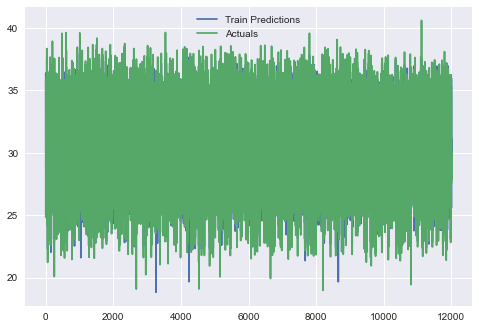

In [21]:
model = load_model('2H_Forecast/2H_ForecastModel_6_SizeWindow/')

X, y = DataHandler(2,6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 3 hours forecast

In [12]:
%%time

Trainer(3,6,9)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 8ms/step - loss: 810.8463 - mean_absolute_error: 28.2498 - val_loss: 572.9001 - val_mean_absolute_error: 23.8258
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 476.4109 - mean_absolute_error: 21.5072 - val_loss: 281.4544 - val_mean_absolute_error: 16.5950
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 9ms/step - loss: 233.8249 - mean_absolute_error: 14.8370 - val_loss: 126.6327 - val_mean_absolute_error: 10.9244
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 7ms/step - loss: 110.9619 - mean_absolute_error: 9.9069 - val_loss: 48.2233 - val_mean_absolute_error: 6.3914
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 45.9042 - mean_absolute_error: 5.9569 - val_loss: 15.7911 - val_mean_absolute_error: 3.1494
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 20.1674 - mean_absolute_error: 3.6258 - val_loss: 7.8502 - val_mean_absolute_error: 2.2849
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 12.8113 - mean_absolute_error: 2.8363 - val_loss: 7.8291 - val_mean_absolute_error: 2.3553
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 12ms/step - loss: 11.0803 - mean_absolute_error: 2.6546 - val_loss: 6.3731 - val_mean_absolute_error: 2.0969
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 7ms/step - loss: 9.2660 - mean_absolute_error: 2.4114 - val_loss: 5.2563 - val_mean_absolute_error: 1.8908
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 7.0598 - mean_absolute_error: 2.0538 - val_loss: 3.4686 - val_mean_absolute_error: 1.4654
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 10ms/step - loss: 5.4495 - mean_absolute_error: 1.7557 - val_loss: 2.8032 - val_mean_absolute_error: 1.2640
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 7ms/step - loss: 4.7648 - mean_absolute_error: 1.6051 - val_loss: 2.5543 - val_mean_absolute_error: 1.1789
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 7ms/step - loss: 4.2260 - mean_absolute_error: 1.4929 - val_loss: 2.2309 - val_mean_absolute_error: 1.1262
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 7ms/step - loss: 3.3368 - mean_absolute_error: 1.3049 - val_loss: 1.6817 - val_mean_absolute_error: 0.8898
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 7ms/step - loss: 2.3606 - mean_absolute_error: 1.0877 - val_loss: 1.2953 - val_mean_absolute_error: 0.8060
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 1.9784 - mean_absolute_error: 0.9930 - val_loss: 1.4379 - val_mean_absolute_error: 0.88251s - loss: 2.1
Epoch 17/25
376/376 [==============================] - 3s 7ms/step - loss: 1.6897 - mean_absolute_error: 0.9163 - val_loss: 1.0948 - val_mean_absolute_error: 0.7222
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 1.3650 - mean_absolute_error: 0.8230 - val_loss: 1.0763 - val_mean_absolute_error: 0.6904
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 1.1037 - mean_absolute_error: 0.7428 - val_loss: 0.9266 - val_mean_absolute_error: 0.6905
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 7ms/step - loss: 0.9745 - mean_absolute_error: 0.6953 - val_loss: 0.8061 - val_mean_absolute_error: 0.5803
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 0.8630 - mean_absolute_error: 0.6544 - val_loss: 0.9018 - val_mean_absolute_error: 0.5939
Epoch 22/25
376/376 [==============================] - 3s 7ms/step - loss: 0.8092 - mean_absolute_error: 0.6325 - val_loss: 0.7526 - val_mean_absolute_error: 0.5637
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 4s 9ms/step - loss: 0.7737 - mean_absolute_error: 0.6188 - val_loss: 0.7823 - val_mean_absolute_error: 0.5861
Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.7433 - mean_absolute_error: 0.6073 - val_loss: 0.6929 - val_mean_absolute_error: 0.5440
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 7ms/step - loss: 0.7236 - mean_absolute_error: 0.5980 - val_loss: 0.5642 - val_mean_absolute_error: 0.5242
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 9ms/step - loss: 830.8063 - mean_absolute_error: 28.6080 - val_loss: 609.7368 - val_mean_absolute_error: 24.5902
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 434.2837 - mean_absolute_error: 20.3907 - val_loss: 199.0717 - val_mean_absolute_error: 13.9298
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 131.6246 - mean_absolute_error: 10.8021 - val_loss: 50.8048 - val_mean_absolute_error: 6.5631
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 8ms/step - loss: 41.3489 - mean_absolute_error: 5.5560 - val_loss: 11.4506 - val_mean_absolute_error: 2.6067
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 14.5627 - mean_absolute_error: 3.0111 - val_loss: 7.0105 - val_mean_absolute_error: 2.0943
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 4s 11ms/step - loss: 10.1590 - mean_absolute_error: 2.5194 - val_loss: 5.9599 - val_mean_absolute_error: 1.9524
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 8.6926 - mean_absolute_error: 2.3303 - val_loss: 6.1226 - val_mean_absolute_error: 1.9895
Epoch 8/25
376/376 [==============================] - 4s 9ms/step - loss: 8.0069 - mean_absolute_error: 2.2226 - val_loss: 5.2578 - val_mean_absolute_error: 1.7891
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 7.4510 - mean_absolute_error: 2.1401 - val_loss: 5.2176 - val_mean_absolute_error: 1.7891
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 6.9547 - mean_absolute_error: 2.0608 - val_loss: 4.7843 - val_mean_absolute_error: 1.6696
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 9ms/step - loss: 6.5740 - mean_absolute_error: 1.9951 - val_loss: 4.4963 - val_mean_absolute_error: 1.5710
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 5s 13ms/step - loss: 5.6999 - mean_absolute_error: 1.8456 - val_loss: 3.7118 - val_mean_absolute_error: 1.3537
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 4s 10ms/step - loss: 4.3086 - mean_absolute_error: 1.5867 - val_loss: 2.9635 - val_mean_absolute_error: 1.1534
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 3.2881 - mean_absolute_error: 1.3690 - val_loss: 2.5005 - val_mean_absolute_error: 1.0482
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 10ms/step - loss: 2.5726 - mean_absolute_error: 1.1952 - val_loss: 1.9569 - val_mean_absolute_error: 0.9510
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.9922 - mean_absolute_error: 1.0340 - val_loss: 1.7341 - val_mean_absolute_error: 0.8734
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 10ms/step - loss: 1.5836 - mean_absolute_error: 0.9055 - val_loss: 1.0977 - val_mean_absolute_error: 0.7527
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 10ms/step - loss: 1.3370 - mean_absolute_error: 0.8246 - val_loss: 0.9247 - val_mean_absolute_error: 0.7190
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 5s 14ms/step - loss: 1.1795 - mean_absolute_error: 0.7688 - val_loss: 0.8982 - val_mean_absolute_error: 0.6946
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 4s 10ms/step - loss: 1.0620 - mean_absolute_error: 0.7256 - val_loss: 0.8007 - val_mean_absolute_error: 0.6699
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 10ms/step - loss: 0.9880 - mean_absolute_error: 0.6984 - val_loss: 0.7543 - val_mean_absolute_error: 0.6337
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 9ms/step - loss: 0.9168 - mean_absolute_error: 0.6710 - val_loss: 0.7454 - val_mean_absolute_error: 0.6181
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8594 - mean_absolute_error: 0.6471 - val_loss: 0.7031 - val_mean_absolute_error: 0.6054
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8057 - mean_absolute_error: 0.6248 - val_loss: 0.6523 - val_mean_absolute_error: 0.5868
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 9ms/step - loss: 0.7760 - mean_absolute_error: 0.6167 - val_loss: 0.7239 - val_mean_absolute_error: 0.5875

-----------------------------------------------------------------------------------------------------------

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 8s 11ms/step - loss: 815.7479 - mean_absolute_erro

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 444.9264 - mean_absolute_error: 20.7214 - val_loss: 242.8527 - val_mean_absolute_error: 15.4171
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 11ms/step - loss: 166.8610 - mean_absolute_error: 12.3392 - val_loss: 68.3947 - val_mean_absolute_error: 7.8181
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 7s 18ms/step - loss: 56.5737 - mean_absolute_error: 6.7004 - val_loss: 18.5911 - val_mean_absolute_error: 3.4619
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 6s 16ms/step - loss: 21.4408 - mean_absolute_error: 3.7551 - val_loss: 8.0947 - val_mean_absolute_error: 2.3148
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 5s 13ms/step - loss: 12.7437 - mean_absolute_error: 2.8310 - val_loss: 7.6077 - val_mean_absolute_error: 2.3124
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 6s 17ms/step - loss: 10.4299 - mean_absolute_error: 2.5632 - val_loss: 6.3954 - val_mean_absolute_error: 2.1092
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 6s 16ms/step - loss: 8.7112 - mean_absolute_error: 2.3178 - val_loss: 4.2492 - val_mean_absolute_error: 1.6426
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 6s 15ms/step - loss: 6.9965 - mean_absolute_error: 2.0587 - val_loss: 4.0223 - val_mean_absolute_error: 1.5707
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 10ms/step - loss: 5.8140 - mean_absolute_error: 1.8578 - val_loss: 3.4939 - val_mean_absolute_error: 1.4582
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 11ms/step - loss: 4.7961 - mean_absolute_error: 1.6663 - val_loss: 2.9761 - val_mean_absolute_error: 1.3528
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 6s 16ms/step - loss: 3.8172 - mean_absolute_error: 1.4665 - val_loss: 2.1479 - val_mean_absolute_error: 1.1221
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 3.1344 - mean_absolute_error: 1.3049 - val_loss: 1.6917 - val_mean_absolute_error: 0.9693
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 5s 12ms/step - loss: 2.5786 - mean_absolute_error: 1.1644 - val_loss: 1.7572 - val_mean_absolute_error: 1.0477
Epoch 15/25
376/376 [==============================] - 5s 14ms/step - loss: 2.1572 - mean_absolute_error: 1.0590 - val_loss: 1.4946 - val_mean_absolute_error: 0.9041
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.4497 - mean_absolute_error: 0.8666 - val_loss: 0.9932 - val_mean_absolute_error: 0.7404
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 5s 12ms/step - loss: 1.0521 - mean_absolute_error: 0.7345 - val_loss: 0.9336 - val_mean_absolute_error: 0.7061
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 10ms/step - loss: 0.9140 - mean_absolute_error: 0.6866 - val_loss: 0.8225 - val_mean_absolute_error: 0.7052
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8364 - mean_absolute_error: 0.6552 - val_loss: 0.8080 - val_mean_absolute_error: 0.6748
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7680 - mean_absolute_error: 0.6224 - val_loss: 0.7048 - val_mean_absolute_error: 0.6367
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7316 - mean_absolute_error: 0.6075 - val_loss: 0.7768 - val_mean_absolute_error: 0.6498
Epoch 22/25
376/376 [==============================] - 3s 9ms/step - loss: 0.7060 - mean_absolute_error: 0.5950 - val_loss: 0.6748 - val_mean_absolute_error: 0.6291
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.6933 - mean_absolute_error: 0.5887 - val_loss: 0.7018 - val_mean_absolute_error: 0.6245
Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.6837 - mean_absolute_error: 0.5845 - val_loss: 0.7636 - val_mean_absolute_error: 0.6577
Epoch 25/25
376/376 [==============================] - 3s 9ms/step - loss: 0.6650 - mean_absolute_error: 0.5752 - val_loss: 0.6012 - val_mean_absolute_error: 0.6080
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 11ms/step - loss: 769.9132 - mean_absolute_error: 27.4925 - val_loss: 522.0798 - val_mean_absolute_error: 22.7222
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 9ms/step - loss: 399.1797 - mean_absolute_error: 19.5547 - val_loss: 206.4371 - val_mean_absolute_error: 14.1560
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 5s 12ms/step - loss: 146.0980 - mean_absolute_error: 11.4178 - val_loss: 48.5100 - val_mean_absolute_error: 6.4427
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 11ms/step - loss: 39.1270 - mean_absolute_error: 5.3809 - val_loss: 10.6442 - val_mean_absolute_error: 2.5432
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 10ms/step - loss: 14.5293 - mean_absolute_error: 3.0051 - val_loss: 5.9485 - val_mean_absolute_error: 1.9595
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 9.5838 - mean_absolute_error: 2.4441 - val_loss: 5.3116 - val_mean_absolute_error: 1.9344
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 10ms/step - loss: 8.0524 - mean_absolute_error: 2.2377 - val_loss: 4.4630 - val_mean_absolute_error: 1.7114
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 5s 13ms/step - loss: 7.0431 - mean_absolute_error: 2.0753 - val_loss: 3.8627 - val_mean_absolute_error: 1.5165
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 5s 14ms/step - loss: 6.0226 - mean_absolute_error: 1.8995 - val_loss: 3.1666 - val_mean_absolute_error: 1.3206
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 11ms/step - loss: 5.1651 - mean_absolute_error: 1.7397 - val_loss: 2.8944 - val_mean_absolute_error: 1.2528
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 11ms/step - loss: 4.2244 - mean_absolute_error: 1.5635 - val_loss: 2.4097 - val_mean_absolute_error: 1.1265
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 4s 10ms/step - loss: 3.3215 - mean_absolute_error: 1.3724 - val_loss: 1.9568 - val_mean_absolute_error: 1.0191
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 4s 10ms/step - loss: 2.2023 - mean_absolute_error: 1.1077 - val_loss: 1.5266 - val_mean_absolute_error: 0.9292
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 1.6874 - mean_absolute_error: 0.9672 - val_loss: 1.1008 - val_mean_absolute_error: 0.8094
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 10ms/step - loss: 1.3757 - mean_absolute_error: 0.8722 - val_loss: 1.0302 - val_mean_absolute_error: 0.7854
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 5s 13ms/step - loss: 1.2008 - mean_absolute_error: 0.8083 - val_loss: 0.8074 - val_mean_absolute_error: 0.6772
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 10ms/step - loss: 1.0964 - mean_absolute_error: 0.7673 - val_loss: 0.8774 - val_mean_absolute_error: 0.6852
Epoch 18/25
376/376 [==============================] - 4s 10ms/step - loss: 0.9833 - mean_absolute_error: 0.7253 - val_loss: 0.9088 - val_mean_absolute_error: 0.7059
Epoch 19/25
376/376 [==============================] - 4s 10ms/step - loss: 0.8955 - mean_absolute_error: 0.6823 - val_loss: 0.8426 - val_mean_absolute_error: 0.6706
Epoch 20/25
376/376 [==============================] - 4s 10ms/step - loss: 0.8425 - mean_absolute_error: 0.6603 - val_loss: 0.7966 - val_mean_absolute_error: 0.6664
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 10ms/step - loss: 0.8082 - mean_absolute_error: 0.6458 - val_loss: 0.7268 - val_mean_absolute_error: 0.6627
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 5s 14ms/step - loss: 0.7740 - mean_absolute_error: 0.6297 - val_loss: 0.6550 - val_mean_absolute_error: 0.6071
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 5s 12ms/step - loss: 0.7439 - mean_absolute_error: 0.6146 - val_loss: 0.6312 - val_mean_absolute_error: 0.5988
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.7143 - mean_absolute_error: 0.6004 - val_loss: 0.6942 - val_mean_absolute_error: 0.6216
Epoch 25/25
376/376 [==============================] - 4s 10ms/step - loss: 0.6935 - mean_absolute_error: 0.5914 - val_loss: 0.6040 - val_mean_absolute_error: 0.5890
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 46min 56s
Wall time: 21min 27s


In [13]:
%%time

modelsEvaluator(3,6,9)

(12009, 6, 5) (12009,) (4003, 6, 5) (4003,) (4004, 6, 5) (4004,)
Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.6776 - mean_absolute_error: 0.5819A: 0s - loss: 0.6760 - mean_absolute_error: 0.581
(12009, 7, 5) (12009,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 0.7921 - mean_absolute_error: 0.6233
(12008, 8, 5) (12008,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 0.6868 - mean_absolute_error: 0.6031A: 0s - loss: 0.7030 - mean_absolute_error: 0.6
(12007, 9, 5) (12007,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 4ms/step - loss: 0.7048 - mean_absolute_error: 0.6016
CPU times: total: 1min
Wall time: 41

126/126 [==============================] - 2s 4ms/step - loss: 0.6890 - mean_absolute_error: 0.5991


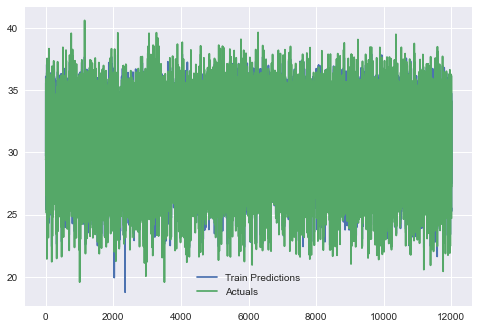

In [22]:
model = load_model('3H_Forecast/3H_ForecastModel_9_SizeWindow/')

X, y = DataHandler(3,9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 4 hours forecast

In [14]:
%%time

Trainer(4,6,9)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 10ms/step - loss: 806.5479 - mean_absolute_error: 28.1604 - val_loss: 541.6504 - val_mean_absolute_error: 23.1596
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 450.8333 - mean_absolute_error: 20.9091 - val_loss: 264.9635 - val_mean_absolute_error: 16.1176
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 204.4314 - mean_absolute_error: 13.7982 - val_loss: 94.2537 - val_mean_absolute_error: 9.3598
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 10ms/step - loss: 77.7388 - mean_absolute_error: 8.0740 - val_loss: 26.8093 - val_mean_absolute_error: 4.4408
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 28.1023 - mean_absolute_error: 4.4185 - val_loss: 9.3688 - val_mean_absolute_error: 2.4297
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 14.0630 - mean_absolute_error: 2.9388 - val_loss: 5.9104 - val_mean_absolute_error: 1.9378
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 10.2354 - mean_absolute_error: 2.5160 - val_loss: 5.8358 - val_mean_absolute_error: 1.9956
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 8.7586 - mean_absolute_error: 2.3365 - val_loss: 4.2785 - val_mean_absolute_error: 1.6041
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 7.9265 - mean_absolute_error: 2.2087 - val_loss: 4.3245 - val_mean_absolute_error: 1.6184
Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 7.4898 - mean_absolute_error: 2.1252 - val_loss: 3.9436 - val_mean_absolute_error: 1.5289
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 8ms/step - loss: 6.5402 - mean_absolute_error: 1.9771 - val_loss: 3.9168 - val_mean_absolute_error: 1.5076A: 2s - loss: 7.1132 - mean_absolute_error:  - ETA: 1s - loss: 7.
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 5.7560 - mean_absolute_error: 1.8434 - val_loss: 3.3795 - val_mean_absolute_error: 1.4046
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 5.1400 - mean_absolute_error: 1.7320 - val_loss: 3.3048 - val_mean_absolute_error: 1.3951
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 4.1932 - mean_absolute_error: 1.5486 - val_loss: 2.1970 - val_mean_absolute_error: 1.1330
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 3.1103 - mean_absolute_error: 1.3164 - val_loss: 1.7951 - val_mean_absolute_error: 1.0295
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 2.4834 - mean_absolute_error: 1.1749 - val_loss: 1.5006 - val_mean_absolute_error: 0.9466
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 2.1197 - mean_absolute_error: 1.0869 - val_loss: 1.4968 - val_mean_absolute_error: 0.9658
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 9ms/step - loss: 1.8876 - mean_absolute_error: 1.0311 - val_loss: 1.4272 - val_mean_absolute_error: 0.9355
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.7258 - mean_absolute_error: 0.9840 - val_loss: 1.3427 - val_mean_absolute_error: 0.9088: 1s - loss: 1.715
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.5903 - mean_absolute_error: 0.9414 - val_loss: 1.2831 - val_mean_absolute_error: 0.8902
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 10ms/step - loss: 1.3991 - mean_absolute_error: 0.8738 - val_loss: 1.1896 - val_mean_absolute_error: 0.8501
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 1.2914 - mean_absolute_error: 0.8354 - val_loss: 1.0410 - val_mean_absolute_error: 0.7906
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 1.2049 - mean_absolute_error: 0.8020 - val_loss: 1.1560 - val_mean_absolute_error: 0.8443
Epoch 24/25
376/376 [==============================] - 5s 13ms/step - loss: 1.0990 - mean_absolute_error: 0.7665 - val_loss: 1.0232 - val_mean_absolute_error: 0.7992
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 4s 10ms/step - loss: 1.0260 - mean_absolute_error: 0.7323 - val_loss: 0.8596 - val_mean_absolute_error: 0.7274
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 10ms/step - loss: 824.3731 - mean_absolute_error: 28.4924 - val_loss: 603.5225 - val_mean_absolute_error: 24.4602
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 471.6786 - mean_absolute_error: 21.3540 - val_loss: 263.0163 - val_mean_absolute_error: 16.0310
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 10ms/step - loss: 207.2613 - mean_absolute_error: 13.8979 - val_loss: 100.9716 - val_mean_absolute_error: 9.6876
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 85.8579 - mean_absolute_error: 8.5550 - val_loss: 33.4444 - val_mean_absolute_error: 5.1098
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 33.9242 - mean_absolute_error: 4.9605 - val_loss: 11.2611 - val_mean_absolute_error: 2.6356
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 4s 10ms/step - loss: 15.7155 - mean_absolute_error: 3.1378 - val_loss: 6.9926 - val_mean_absolute_error: 2.1862
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 10.6786 - mean_absolute_error: 2.5921 - val_loss: 6.3819 - val_mean_absolute_error: 2.1375
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 11ms/step - loss: 8.8134 - mean_absolute_error: 2.3424 - val_loss: 3.7927 - val_mean_absolute_error: 1.5414
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 6.7378 - mean_absolute_error: 2.0207 - val_loss: 3.7914 - val_mean_absolute_error: 1.5470
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 8ms/step - loss: 6.2459 - mean_absolute_error: 1.9267 - val_loss: 3.6991 - val_mean_absolute_error: 1.5394
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 10ms/step - loss: 5.6190 - mean_absolute_error: 1.8047 - val_loss: 2.9813 - val_mean_absolute_error: 1.3510
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 4.9877 - mean_absolute_error: 1.6739 - val_loss: 2.7978 - val_mean_absolute_error: 1.2931
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 4.3079 - mean_absolute_error: 1.5317 - val_loss: 2.5990 - val_mean_absolute_error: 1.2217
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 3.5484 - mean_absolute_error: 1.3753 - val_loss: 2.2033 - val_mean_absolute_error: 1.1160
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 11ms/step - loss: 2.9707 - mean_absolute_error: 1.2548 - val_loss: 1.8093 - val_mean_absolute_error: 1.0381
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 9ms/step - loss: 2.5018 - mean_absolute_error: 1.1497 - val_loss: 1.7367 - val_mean_absolute_error: 1.0395
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 12ms/step - loss: 2.1976 - mean_absolute_error: 1.0743 - val_loss: 1.4960 - val_mean_absolute_error: 0.9505
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 8ms/step - loss: 1.9641 - mean_absolute_error: 1.0183 - val_loss: 1.4219 - val_mean_absolute_error: 0.9227
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.7720 - mean_absolute_error: 0.9722 - val_loss: 1.5569 - val_mean_absolute_error: 0.9646
Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.5891 - mean_absolute_error: 0.9194 - val_loss: 1.2884 - val_mean_absolute_error: 0.8833
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 1.4489 - mean_absolute_error: 0.8785 - val_loss: 1.2670 - val_mean_absolute_error: 0.8698
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 1.2947 - mean_absolute_error: 0.8298 - val_loss: 1.2552 - val_mean_absolute_error: 0.8526
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 1.1898 - mean_absolute_error: 0.7904 - val_loss: 1.1280 - val_mean_absolute_error: 0.7994
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0828 - mean_absolute_error: 0.7470 - val_loss: 1.0084 - val_mean_absolute_error: 0.7578
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0153 - mean_absolute_error: 0.7225 - val_loss: 0.9735 - val_mean_absolute_error: 0.7386
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 9s 15ms/step - loss: 786.0972 - mean_absolute_error: 27.8117 - val_loss: 545.6917 - val_mean_absolute_error: 23.2685
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 336.2123 - mean_absolute_error: 17.7001 - val_loss: 123.4454 - val_mean_absolute_error: 10.8210
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 9ms/step - loss: 88.2965 - mean_absolute_error: 8.6468 - val_loss: 28.0335 - val_mean_absolute_error: 4.5826
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 24.1800 - mean_absolute_error: 4.0239 - val_loss: 7.8870 - val_mean_absolute_error: 2.2086
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 9ms/step - loss: 11.5117 - mean_absolute_error: 2.6781 - val_loss: 6.7251 - val_mean_absolute_error: 2.1099
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 5s 13ms/step - loss: 9.3323 - mean_absolute_error: 2.4158 - val_loss: 5.3899 - val_mean_absolute_error: 1.8298.630
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 10ms/step - loss: 8.2633 - mean_absolute_error: 2.2579 - val_loss: 5.5557 - val_mean_absolute_error: 1.854314
Epoch 8/25
376/376 [==============================] - 3s 9ms/step - loss: 7.9067 - mean_absolute_error: 2.1991 - val_loss: 5.3070 - val_mean_absolute_error: 1.7950
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 4s 9ms/step - loss: 7.5278 - mean_absolute_error: 2.1373 - val_loss: 5.1134 - val_mean_absolute_error: 1.7046
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 9ms/step - loss: 7.0296 - mean_absolute_error: 2.0587 - val_loss: 4.3858 - val_mean_absolute_error: 1.5553
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 11ms/step - loss: 6.3269 - mean_absolute_error: 1.9423 - val_loss: 3.9925 - val_mean_absolute_error: 1.4864
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 5.3422 - mean_absolute_error: 1.7764 - val_loss: 3.4191 - val_mean_absolute_error: 1.2965
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 4.3253 - mean_absolute_error: 1.5998 - val_loss: 2.9602 - val_mean_absolute_error: 1.1825
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 3.5482 - mean_absolute_error: 1.4424 - val_loss: 3.0066 - val_mean_absolute_error: 1.1659
Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 2.5951 - mean_absolute_error: 1.2253 - val_loss: 2.0863 - val_mean_absolute_error: 0.9681
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.8177 - mean_absolute_error: 1.0096 - val_loss: 1.8366 - val_mean_absolute_error: 0.9217
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 1.4007 - mean_absolute_error: 0.8726 - val_loss: 1.5433 - val_mean_absolute_error: 0.8139
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 9ms/step - loss: 1.1498 - mean_absolute_error: 0.7769 - val_loss: 1.4681 - val_mean_absolute_error: 0.7712
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0319 - mean_absolute_error: 0.7294 - val_loss: 1.5257 - val_mean_absolute_error: 0.7699
Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9679 - mean_absolute_error: 0.7045 - val_loss: 1.3644 - val_mean_absolute_error: 0.7333
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9196 - mean_absolute_error: 0.6869 - val_loss: 1.3274 - val_mean_absolute_error: 0.7308
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.8808 - mean_absolute_error: 0.6726 - val_loss: 1.2889 - val_mean_absolute_error: 0.7141
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8503 - mean_absolute_error: 0.6590 - val_loss: 1.1703 - val_mean_absolute_error: 0.7066
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 10ms/step - loss: 0.8307 - mean_absolute_error: 0.6527 - val_loss: 1.2797 - val_mean_absolute_error: 0.7150
Epoch 25/25
376/376 [==============================] - 4s 11ms/step - loss: 0.7995 - mean_absolute_error: 0.6388 - val_loss: 1.1911 - val_mean_absolute_error: 0.6953

-----------------------------------------------------------------------------------------------------------

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
___

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 614.0771 - mean_absolute_error: 24.5101 - val_loss: 404.1632 - val_mean_absolute_error: 19.9596
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 340.9027 - mean_absolute_error: 18.0984 - val_loss: 203.2971 - val_mean_absolute_error: 14.0153
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 8ms/step - loss: 166.3945 - mean_absolute_error: 12.3524 - val_loss: 79.4092 - val_mean_absolute_error: 8.4787
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 9ms/step - loss: 69.6095 - mean_absolute_error: 7.5891 - val_loss: 26.7010 - val_mean_absolute_error: 4.3644
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 28.6149 - mean_absolute_error: 4.4777 - val_loss: 10.5377 - val_mean_absolute_error: 2.5354
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 8ms/step - loss: 14.2394 - mean_absolute_error: 2.9849 - val_loss: 8.0719 - val_mean_absolute_error: 2.3492
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 9ms/step - loss: 11.4606 - mean_absolute_error: 2.6980 - val_loss: 7.7744 - val_mean_absolute_error: 2.3143
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 4s 10ms/step - loss: 9.5613 - mean_absolute_error: 2.4467 - val_loss: 5.7926 - val_mean_absolute_error: 1.9126
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 9ms/step - loss: 8.3405 - mean_absolute_error: 2.2721 - val_loss: 5.0254 - val_mean_absolute_error: 1.6763
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 10ms/step - loss: 7.7658 - mean_absolute_error: 2.1857 - val_loss: 5.1063 - val_mean_absolute_error: 1.6983
Epoch 12/25
376/376 [==============================] - 4s 11ms/step - loss: 7.6027 - mean_absolute_error: 2.1574 - val_loss: 5.0900 - val_mean_absolute_error: 1.6847
Epoch 13/25
376/376 [==============================] - 4s 11ms/step - loss: 7.4106 - mean_absolute_error: 2.1265 - val_loss: 4.9206 - val_mean_absolute_error: 1.6853
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 7.0232 - mean_absolute_error: 2.0707 - val_loss: 4.5319 - val_mean_absolute_error: 1.6254
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 6.6969 - mean_absolute_error: 2.0191 - val_loss: 4.4889 - val_mean_absolute_error: 1.5938
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 6.1887 - mean_absolute_error: 1.9341 - val_loss: 3.9353 - val_mean_absolute_error: 1.4809
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 11ms/step - loss: 5.3095 - mean_absolute_error: 1.7850 - val_loss: 3.4212 - val_mean_absolute_error: 1.3407
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 9ms/step - loss: 3.7970 - mean_absolute_error: 1.4857 - val_loss: 2.8243 - val_mean_absolute_error: 1.1375
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 4s 10ms/step - loss: 2.3941 - mean_absolute_error: 1.1551 - val_loss: 1.9612 - val_mean_absolute_error: 0.9848
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 1.7036 - mean_absolute_error: 0.9547 - val_loss: 1.5533 - val_mean_absolute_error: 0.8947
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 4s 10ms/step - loss: 1.2833 - mean_absolute_error: 0.8088 - val_loss: 1.6405 - val_mean_absolute_error: 0.8997
Epoch 22/25
376/376 [==============================] - 5s 12ms/step - loss: 1.0270 - mean_absolute_error: 0.7193 - val_loss: 1.2471 - val_mean_absolute_error: 0.7299
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9227 - mean_absolute_error: 0.6833 - val_loss: 1.3096 - val_mean_absolute_error: 0.7492
Epoch 24/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8641 - mean_absolute_error: 0.6568 - val_loss: 1.2745 - val_mean_absolute_error: 0.7068
Epoch 25/25
376/376 [==============================] - 4s 10ms/step - loss: 0.8238 - mean_absolute_error: 0.6406 - val_loss: 1.0595 - val_mean_absolute_error: 0.6887
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 46min 49s
Wall time: 20min 15s


In [15]:
%%time

modelsEvaluator(4,6,9)

(12009, 6, 5) (12009,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 1.0271 - mean_absolute_error: 0.7431
(12008, 7, 5) (12008,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 1.0069 - mean_absolute_error: 0.7307
(12007, 8, 5) (12007,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.9214 - mean_absolute_error: 0.6863
(12006, 9, 5) (12006,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.8963 - mean_absolute_error: 0.6666
CPU times: total: 58.2 s
Wall time: 38.9 s


126/126 [==============================] - 1s 4ms/step - loss: 0.8985 - mean_absolute_error: 0.6696


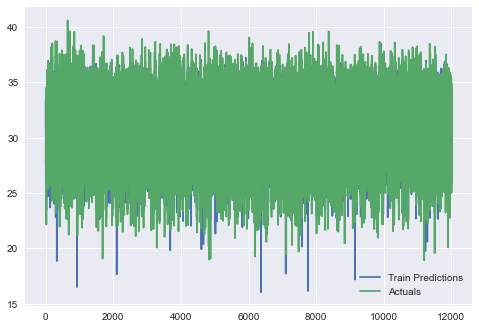

In [23]:
model = load_model('4H_Forecast/4H_ForecastModel_9_SizeWindow/')

X, y = DataHandler(4,9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 5 hours forecast

In [16]:
%%time

Trainer(5,6,9)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 10ms/step - loss: 812.4307 - mean_absolute_error: 28.2795 - val_loss: 588.8939 - val_mean_absolute_error: 24.1459
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 470.3640 - mean_absolute_error: 21.3131 - val_loss: 248.9903 - val_mean_absolute_error: 15.6067
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 174.2681 - mean_absolute_error: 12.6320 - val_loss: 69.3242 - val_mean_absolute_error: 7.9908
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 8ms/step - loss: 52.1031 - mean_absolute_error: 6.3947 - val_loss: 15.5984 - val_mean_absolute_error: 3.1470
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 18.7321 - mean_absolute_error: 3.4692 - val_loss: 7.5596 - val_mean_absolute_error: 2.2190
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 7ms/step - loss: 11.8723 - mean_absolute_error: 2.7258 - val_loss: 6.1214 - val_mean_absolute_error: 2.0112
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 7ms/step - loss: 9.6040 - mean_absolute_error: 2.4540 - val_loss: 5.2856 - val_mean_absolute_error: 1.8490
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 8.3753 - mean_absolute_error: 2.2758 - val_loss: 4.9221 - val_mean_absolute_error: 1.6966
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 6.9663 - mean_absolute_error: 2.0547 - val_loss: 3.8168 - val_mean_absolute_error: 1.4690
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 5.8820 - mean_absolute_error: 1.8754 - val_loss: 3.5974 - val_mean_absolute_error: 1.4330
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 7ms/step - loss: 5.3797 - mean_absolute_error: 1.7886 - val_loss: 3.3968 - val_mean_absolute_error: 1.3614
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 5.0246 - mean_absolute_error: 1.7155 - val_loss: 3.1471 - val_mean_absolute_error: 1.3224
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 7ms/step - loss: 4.5811 - mean_absolute_error: 1.6200 - val_loss: 2.9904 - val_mean_absolute_error: 1.2471
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 4.0982 - mean_absolute_error: 1.5187 - val_loss: 2.6027 - val_mean_absolute_error: 1.1864
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 3.3532 - mean_absolute_error: 1.3634 - val_loss: 2.3431 - val_mean_absolute_error: 1.1406
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 9ms/step - loss: 2.6998 - mean_absolute_error: 1.2117 - val_loss: 2.1881 - val_mean_absolute_error: 1.1171
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 10ms/step - loss: 2.3160 - mean_absolute_error: 1.1131 - val_loss: 1.8115 - val_mean_absolute_error: 1.0029
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 2.0044 - mean_absolute_error: 1.0275 - val_loss: 1.6455 - val_mean_absolute_error: 0.9786
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 1.6272 - mean_absolute_error: 0.9222 - val_loss: 1.3710 - val_mean_absolute_error: 0.9013
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.3065 - mean_absolute_error: 0.8228 - val_loss: 1.2429 - val_mean_absolute_error: 0.8439
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 1.2127 - mean_absolute_error: 0.7933 - val_loss: 1.2876 - val_mean_absolute_error: 0.8521
Epoch 22/25
376/376 [==============================] - 3s 7ms/step - loss: 1.1335 - mean_absolute_error: 0.7661 - val_loss: 1.1013 - val_mean_absolute_error: 0.7868
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 6s 15ms/step - loss: 1.0493 - mean_absolute_error: 0.7334 - val_loss: 1.0541 - val_mean_absolute_error: 0.7906
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0114 - mean_absolute_error: 0.7213 - val_loss: 1.0839 - val_mean_absolute_error: 0.8009
Epoch 25/25
376/376 [==============================] - 3s 7ms/step - loss: 0.9665 - mean_absolute_error: 0.7086 - val_loss: 0.9529 - val_mean_absolute_error: 0.7369
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 7s 10ms/step - loss: 871.5069 - mean_absolute_error: 29.3082 - val_loss: 672.2249 - val_mean_absolute_error: 25.8132
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 8ms/step - loss: 561.2504 - mean_absolute_error: 23.3789 - val_loss: 363.4273 - val_mean_absolute_error: 18.8890
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 8ms/step - loss: 327.2499 - mean_absolute_error: 17.7322 - val_loss: 204.7230 - val_mean_absolute_error: 14.0613
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 9ms/step - loss: 182.2996 - mean_absolute_error: 13.0174 - val_loss: 99.0416 - val_mean_absolute_error: 9.5757
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 9ms/step - loss: 87.8233 - mean_absolute_error: 8.6806 - val_loss: 37.8540 - val_mean_absolute_error: 5.5161
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 39.0956 - mean_absolute_error: 5.4162 - val_loss: 14.1026 - val_mean_absolute_error: 2.9553
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 3s 9ms/step - loss: 19.0673 - mean_absolute_error: 3.5041 - val_loss: 7.9035 - val_mean_absolute_error: 2.2946
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 12.5432 - mean_absolute_error: 2.7979 - val_loss: 6.5663 - val_mean_absolute_error: 2.1135
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 9.7563 - mean_absolute_error: 2.4586 - val_loss: 4.9514 - val_mean_absolute_error: 1.7664
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 9ms/step - loss: 8.3201 - mean_absolute_error: 2.2628 - val_loss: 4.2152 - val_mean_absolute_error: 1.5898
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 8ms/step - loss: 7.4478 - mean_absolute_error: 2.1307 - val_loss: 4.0185 - val_mean_absolute_error: 1.5553
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 6.9528 - mean_absolute_error: 2.0533 - val_loss: 3.7922 - val_mean_absolute_error: 1.4794
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 6.4282 - mean_absolute_error: 1.9708 - val_loss: 3.6785 - val_mean_absolute_error: 1.4576 - mean_abso
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 9ms/step - loss: 5.9666 - mean_absolute_error: 1.8891 - val_loss: 3.5705 - val_mean_absolute_error: 1.4138
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 8ms/step - loss: 5.4183 - mean_absolute_error: 1.7958 - val_loss: 2.9761 - val_mean_absolute_error: 1.2992olute_error:
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 4.3529 - mean_absolute_error: 1.6015 - val_loss: 2.4729 - val_mean_absolute_error: 1.1838
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 8ms/step - loss: 3.4131 - mean_absolute_error: 1.4043 - val_loss: 2.0718 - val_mean_absolute_error: 1.1357 3.4542 - mean_absolute_error: 
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 7ms/step - loss: 2.5432 - mean_absolute_error: 1.2022 - val_loss: 1.5002 - val_mean_absolute_error: 0.9744
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 1.9802 - mean_absolute_error: 1.0466 - val_loss: 1.2465 - val_mean_absolute_error: 0.8768
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 7ms/step - loss: 1.6504 - mean_absolute_error: 0.9472 - val_loss: 1.0126 - val_mean_absolute_error: 0.7970
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 8ms/step - loss: 1.4004 - mean_absolute_error: 0.8657 - val_loss: 1.0052 - val_mean_absolute_error: 0.7981
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 9ms/step - loss: 1.2680 - mean_absolute_error: 0.8172 - val_loss: 0.8986 - val_mean_absolute_error: 0.7503
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 7ms/step - loss: 1.1513 - mean_absolute_error: 0.7746 - val_loss: 0.8349 - val_mean_absolute_error: 0.7373
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0745 - mean_absolute_error: 0.7470 - val_loss: 0.9773 - val_mean_absolute_error: 0.7757
Epoch 25/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0227 - mean_absolute_error: 0.7284 - val_loss: 0.8363 - val_mean_absolute_error: 0.7013

-----------------------------------------------------------------------------------------------------------

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_____

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 7ms/step - loss: 508.7871 - mean_absolute_error: 22.2158 - val_loss: 286.5551 - val_mean_absolute_error: 16.7708
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 9ms/step - loss: 205.5609 - mean_absolute_error: 13.8109 - val_loss: 91.6272 - val_mean_absolute_error: 9.1956
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 8ms/step - loss: 70.6682 - mean_absolute_error: 7.6489 - val_loss: 24.7145 - val_mean_absolute_error: 4.1273
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 9ms/step - loss: 23.8477 - mean_absolute_error: 4.0063 - val_loss: 9.7439 - val_mean_absolute_error: 2.3777
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 12.7904 - mean_absolute_error: 2.8276 - val_loss: 8.2138 - val_mean_absolute_error: 2.2395
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 10ms/step - loss: 10.1067 - mean_absolute_error: 2.5118 - val_loss: 6.6913 - val_mean_absolute_error: 1.9597
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 8ms/step - loss: 8.8351 - mean_absolute_error: 2.3418 - val_loss: 6.8138 - val_mean_absolute_error: 1.9675
Epoch 9/25
376/376 [==============================] - 3s 8ms/step - loss: 8.0327 - mean_absolute_error: 2.2195 - val_loss: 6.2644 - val_mean_absolute_error: 1.7859
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 9ms/step - loss: 7.5352 - mean_absolute_error: 2.1402 - val_loss: 6.2355 - val_mean_absolute_error: 1.7542
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 8ms/step - loss: 7.1221 - mean_absolute_error: 2.0728 - val_loss: 5.3708 - val_mean_absolute_error: 1.5721
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 8ms/step - loss: 6.4736 - mean_absolute_error: 1.9736 - val_loss: 5.5154 - val_mean_absolute_error: 1.5955
Epoch 13/25
376/376 [==============================] - 3s 8ms/step - loss: 5.6835 - mean_absolute_error: 1.8378 - val_loss: 5.4098 - val_mean_absolute_error: 1.6170
Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 3.9678 - mean_absolute_error: 1.5093 - val_loss: 4.6562 - val_mean_absolute_error: 1.3946
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 2.8204 - mean_absolute_error: 1.2656 - val_loss: 3.5209 - val_mean_absolute_error: 1.2467
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 1.9569 - mean_absolute_error: 1.0524 - val_loss: 2.7891 - val_mean_absolute_error: 1.0573
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 7ms/step - loss: 1.5368 - mean_absolute_error: 0.9257 - val_loss: 2.5062 - val_mean_absolute_error: 0.9554
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 8ms/step - loss: 1.2812 - mean_absolute_error: 0.8425 - val_loss: 1.9081 - val_mean_absolute_error: 0.8319
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.1420 - mean_absolute_error: 0.7896 - val_loss: 1.7105 - val_mean_absolute_error: 0.7938
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 7ms/step - loss: 1.0696 - mean_absolute_error: 0.7585 - val_loss: 1.7056 - val_mean_absolute_error: 0.8017
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 9ms/step - loss: 1.0191 - mean_absolute_error: 0.7338 - val_loss: 1.4496 - val_mean_absolute_error: 0.7550olu
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9747 - mean_absolute_error: 0.7150 - val_loss: 1.3755 - val_mean_absolute_error: 0.7430
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9496 - mean_absolute_error: 0.7028 - val_loss: 1.2569 - val_mean_absolute_error: 0.7523
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9306 - mean_absolute_error: 0.6936 - val_loss: 1.3434 - val_mean_absolute_error: 0.7474
Epoch 25/25
376/376 [==============================] - 4s 12ms/step - loss: 0.9043 - mean_absolute_error: 0.6816 - val_loss: 1.1626 - val_mean_absolute_error: 0.7261
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 6s 9ms/step - loss: 761.3252 - mean_absolute_error: 27.3350 - val_loss: 465.4436 - val_mean_absolute_error: 21.4658
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 3s 9ms/step - loss: 301.7202 - mean_absolute_error: 16.8476 - val_loss: 127.6192 - val_mean_absolute_error: 10.9934
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 10ms/step - loss: 91.6003 - mean_absolute_error: 8.8147 - val_loss: 30.9325 - val_mean_absolute_error: 4.8505
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 3s 8ms/step - loss: 29.6255 - mean_absolute_error: 4.5526 - val_loss: 9.2847 - val_mean_absolute_error: 2.4192
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 8ms/step - loss: 13.8755 - mean_absolute_error: 2.9479 - val_loss: 7.6197 - val_mean_absolute_error: 2.2980
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 3s 8ms/step - loss: 10.8420 - mean_absolute_error: 2.6174 - val_loss: 6.1019 - val_mean_absolute_error: 2.0221
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 10ms/step - loss: 8.7489 - mean_absolute_error: 2.3261 - val_loss: 5.3339 - val_mean_absolute_error: 1.8360
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 9ms/step - loss: 8.0061 - mean_absolute_error: 2.2144 - val_loss: 5.1525 - val_mean_absolute_error: 1.7326
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 3s 9ms/step - loss: 7.5852 - mean_absolute_error: 2.1460 - val_loss: 4.7190 - val_mean_absolute_error: 1.6674
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 9ms/step - loss: 7.2349 - mean_absolute_error: 2.0853 - val_loss: 4.4498 - val_mean_absolute_error: 1.6163
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 10ms/step - loss: 6.7105 - mean_absolute_error: 2.0011 - val_loss: 4.1094 - val_mean_absolute_error: 1.5309
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 5.9633 - mean_absolute_error: 1.8783 - val_loss: 3.7054 - val_mean_absolute_error: 1.4462
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 9ms/step - loss: 5.0747 - mean_absolute_error: 1.7158 - val_loss: 3.4869 - val_mean_absolute_error: 1.3789
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 4.1612 - mean_absolute_error: 1.5444 - val_loss: 3.1497 - val_mean_absolute_error: 1.2906- loss: 4.6224 - mean_absolute_err - ETA: 1s - loss: 4.4
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 3.3864 - mean_absolute_error: 1.3874 - val_loss: 2.8481 - val_mean_absolute_error: 1.2010
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 3s 8ms/step - loss: 2.5336 - mean_absolute_error: 1.1867 - val_loss: 2.1375 - val_mean_absolute_error: 1.1218
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 8ms/step - loss: 2.0202 - mean_absolute_error: 1.0495 - val_loss: 1.7083 - val_mean_absolute_error: 0.9696
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 9ms/step - loss: 1.5955 - mean_absolute_error: 0.9172 - val_loss: 1.5876 - val_mean_absolute_error: 0.9202
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 9ms/step - loss: 1.2916 - mean_absolute_error: 0.8176 - val_loss: 1.2123 - val_mean_absolute_error: 0.8384
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 8ms/step - loss: 1.1108 - mean_absolute_error: 0.7551 - val_loss: 1.2930 - val_mean_absolute_error: 0.8278
Epoch 21/25
376/376 [==============================] - 4s 11ms/step - loss: 1.0119 - mean_absolute_error: 0.7105 - val_loss: 1.0844 - val_mean_absolute_error: 0.7522
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9590 - mean_absolute_error: 0.6905 - val_loss: 1.1126 - val_mean_absolute_error: 0.7890
Epoch 23/25
376/376 [==============================] - 3s 8ms/step - loss: 0.9202 - mean_absolute_error: 0.6775 - val_loss: 0.9831 - val_mean_absolute_error: 0.7275
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 11ms/step - loss: 0.9285 - mean_absolute_error: 0.6803 - val_loss: 0.9607 - val_mean_absolute_error: 0.7237
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 3s 9ms/step - loss: 0.8875 - mean_absolute_error: 0.6629 - val_loss: 0.9405 - val_mean_absolute_error: 0.70998772 - mean_absol
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 47min 23s
Wall time: 18min 54s


In [17]:
%%time

modelsEvaluator(5,6,9)

(12008, 6, 5) (12008,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.9702 - mean_absolute_error: 0.7142
(12007, 7, 5) (12007,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 1.0632 - mean_absolute_error: 0.7670A: 0s - loss: 1.0632 - mean_absolute_error: 0.767
(12006, 8, 5) (12006,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 1s 2ms/step - loss: 0.9530 - mean_absolute_error: 0.7065A: 0s - loss: 0.9809 - mean_absolute_error: 0.70
(12006, 9, 5) (12006,) (4002, 9, 5) (4002,) (4003, 9, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 0.9138 - mean_absolute_error: 0.6703
CPU times: total: 55.6 s
Wall time:

126/126 [==============================] - 1s 4ms/step - loss: 0.8927 - mean_absolute_error: 0.6701


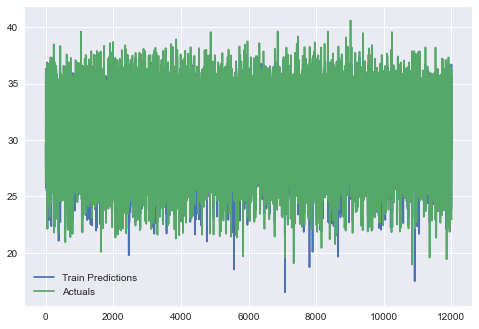

In [24]:
model = load_model('5H_Forecast/5H_ForecastModel_9_SizeWindow/')

X, y = DataHandler(5,9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 6 hours forecast

In [18]:
%%time

Trainer(6,6,9)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 8ms/step - loss: 792.4453 - mean_absolute_error: 27.9119 - val_loss: 576.8563 - val_mean_absolute_error: 23.8981
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 2s 6ms/step - loss: 495.7372 - mean_absolute_error: 21.9571 - val_loss: 308.9860 - val_mean_absolute_error: 17.3804
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 2s 6ms/step - loss: 251.7880 - mean_absolute_error: 15.4001 - val_loss: 136.5468 - val_mean_absolute_error: 11.3668
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 2s 6ms/step - loss: 114.3071 - mean_absolute_error: 10.0437 - val_loss: 47.4103 - val_mean_absolute_error: 6.3303
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 2s 6ms/step - loss: 42.9772 - mean_absolute_error: 5.7046 - val_loss: 13.5805 - val_mean_absolute_error: 2.9026
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 2s 6ms/step - loss: 18.3408 - mean_absolute_error: 3.4257 - val_loss: 7.4403 - val_mean_absolute_error: 2.2426
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 2s 6ms/step - loss: 11.1688 - mean_absolute_error: 2.6311 - val_loss: 5.0556 - val_mean_absolute_error: 1.8388
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 9.0962 - mean_absolute_error: 2.3795 - val_loss: 4.8331 - val_mean_absolute_error: 1.8022
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 2s 6ms/step - loss: 8.1906 - mean_absolute_error: 2.2436 - val_loss: 4.3867 - val_mean_absolute_error: 1.6515
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 3s 7ms/step - loss: 7.7566 - mean_absolute_error: 2.1801 - val_loss: 4.2253 - val_mean_absolute_error: 1.6085
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 2s 6ms/step - loss: 6.7693 - mean_absolute_error: 2.0316 - val_loss: 3.7512 - val_mean_absolute_error: 1.5063
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 2s 6ms/step - loss: 5.6390 - mean_absolute_error: 1.8342 - val_loss: 3.5658 - val_mean_absolute_error: 1.4976
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 2s 6ms/step - loss: 4.9935 - mean_absolute_error: 1.7199 - val_loss: 3.0118 - val_mean_absolute_error: 1.3486
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 7ms/step - loss: 4.5452 - mean_absolute_error: 1.6324 - val_loss: 2.7603 - val_mean_absolute_error: 1.2845
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 2s 6ms/step - loss: 4.1785 - mean_absolute_error: 1.5546 - val_loss: 2.4935 - val_mean_absolute_error: 1.2150
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 2s 6ms/step - loss: 3.7773 - mean_absolute_error: 1.4697 - val_loss: 2.0717 - val_mean_absolute_error: 1.1082
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 2s 6ms/step - loss: 2.9729 - mean_absolute_error: 1.2880 - val_loss: 1.7081 - val_mean_absolute_error: 1.0029
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 2s 7ms/step - loss: 2.3831 - mean_absolute_error: 1.1468 - val_loss: 1.4080 - val_mean_absolute_error: 0.9096
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 3s 7ms/step - loss: 1.9019 - mean_absolute_error: 1.0111 - val_loss: 1.1425 - val_mean_absolute_error: 0.8287
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 2s 6ms/step - loss: 1.5550 - mean_absolute_error: 0.9038 - val_loss: 1.2234 - val_mean_absolute_error: 0.8362
Epoch 21/25
376/376 [==============================] - 3s 7ms/step - loss: 1.4268 - mean_absolute_error: 0.8663 - val_loss: 1.0933 - val_mean_absolute_error: 0.8227
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 2s 6ms/step - loss: 1.3557 - mean_absolute_error: 0.8430 - val_loss: 1.0265 - val_mean_absolute_error: 0.7983
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 2s 6ms/step - loss: 1.3104 - mean_absolute_error: 0.8313 - val_loss: 1.1021 - val_mean_absolute_error: 0.8090
Epoch 24/25
376/376 [==============================] - 2s 6ms/step - loss: 1.2675 - mean_absolute_error: 0.8199 - val_loss: 0.9752 - val_mean_absolute_error: 0.7792
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
376/376 [==============================] - 2s 7ms/step - loss: 1.2415 - mean_absolute_error: 0.8118 - val_loss: 0.9927 - val_mean_absolute_error: 0.8104

-----------------------------------------------------------------------------------------------------------

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 5s 8ms/step - loss: 730.0942 - mean_absolute_error

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 2s 7ms/step - loss: 230.8159 - mean_absolute_error: 14.2055 - val_loss: 40.1304 - val_mean_absolute_error: 5.8487
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 3s 7ms/step - loss: 24.2927 - mean_absolute_error: 4.0086 - val_loss: 6.8172 - val_mean_absolute_error: 1.9907
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 2s 7ms/step - loss: 10.0422 - mean_absolute_error: 2.4987 - val_loss: 5.0182 - val_mean_absolute_error: 1.7402
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 3s 7ms/step - loss: 8.4486 - mean_absolute_error: 2.2978 - val_loss: 5.1439 - val_mean_absolute_error: 1.7883
Epoch 6/25
376/376 [==============================] - 3s 9ms/step - loss: 8.1611 - mean_absolute_error: 2.2491 - val_loss: 5.1075 - val_mean_absolute_error: 1.7656
Epoch 7/25
376/376 [==============================] - 3s 9ms/step - loss: 8.0149 - mean_absolute_error: 2.2188 - val_loss: 4.9145 - val_mean_absolute_error: 1.7144
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 3s 7ms/step - loss: 7.8712 - mean_absolute_error: 2.1914 - val_loss: 4.9593 - val_mean_absolute_error: 1.7336
Epoch 9/25
376/376 [==============================] - 2s 6ms/step - loss: 7.5167 - mean_absolute_error: 2.1369 - val_loss: 4.5903 - val_mean_absolute_error: 1.6615
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 2s 7ms/step - loss: 6.5259 - mean_absolute_error: 1.9886 - val_loss: 4.2956 - val_mean_absolute_error: 1.5980
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 8ms/step - loss: 6.0866 - mean_absolute_error: 1.9121 - val_loss: 4.2107 - val_mean_absolute_error: 1.5686
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 5.4983 - mean_absolute_error: 1.8107 - val_loss: 3.8792 - val_mean_absolute_error: 1.5127
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 3s 7ms/step - loss: 4.5820 - mean_absolute_error: 1.6493 - val_loss: 3.1838 - val_mean_absolute_error: 1.3531A: 1s - loss: 
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 3s 8ms/step - loss: 3.3689 - mean_absolute_error: 1.3946 - val_loss: 2.3428 - val_mean_absolute_error: 1.1603
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 2.5840 - mean_absolute_error: 1.2071 - val_loss: 2.0549 - val_mean_absolute_error: 1.0667
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 1.9119 - mean_absolute_error: 1.0221 - val_loss: 1.6511 - val_mean_absolute_error: 0.9626
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 1.4852 - mean_absolute_error: 0.8874 - val_loss: 1.1609 - val_mean_absolute_error: 0.8233
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 3s 8ms/step - loss: 1.2971 - mean_absolute_error: 0.8147 - val_loss: 1.2162 - val_mean_absolute_error: 0.8306
Epoch 19/25
376/376 [==============================] - 3s 8ms/step - loss: 1.1937 - mean_absolute_error: 0.7764 - val_loss: 0.9975 - val_mean_absolute_error: 0.7729
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 1.1333 - mean_absolute_error: 0.7593 - val_loss: 0.9875 - val_mean_absolute_error: 0.7412
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0722 - mean_absolute_error: 0.7322 - val_loss: 1.0054 - val_mean_absolute_error: 0.7536
Epoch 22/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0668 - mean_absolute_error: 0.7340 - val_loss: 0.8993 - val_mean_absolute_error: 0.7225
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0380 - mean_absolute_error: 0.7235 - val_loss: 0.8942 - val_mean_absolute_error: 0.7390
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 3s 8ms/step - loss: 1.0168 - mean_absolute_error: 0.7152 - val_loss: 1.0909 - val_mean_absolute_error: 0.7884
Epoch 25/25
376/376 [==============================] - 3s 9ms/step - loss: 0.9971 - mean_absolute_error: 0.7106 - val_loss: 0.9095 - val_mean_absolute_error: 0.7300

-----------------------------------------------------------------------------------------------------------

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_____

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 4s 10ms/step - loss: 387.7844 - mean_absolute_error: 19.1973 - val_loss: 162.9021 - val_mean_absolute_error: 12.5374
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 6s 17ms/step - loss: 114.6694 - mean_absolute_error: 10.0134 - val_loss: 40.7201 - val_mean_absolute_error: 5.7564
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 10ms/step - loss: 34.0922 - mean_absolute_error: 4.9370 - val_loss: 10.2370 - val_mean_absolute_error: 2.5152
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 10ms/step - loss: 14.2808 - mean_absolute_error: 2.9770 - val_loss: 7.0631 - val_mean_absolute_error: 2.1682
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 8s 20ms/step - loss: 10.5353 - mean_absolute_error: 2.5754 - val_loss: 6.2414 - val_mean_absolute_error: 2.0701
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 11ms/step - loss: 9.1213 - mean_absolute_error: 2.3848 - val_loss: 4.8043 - val_mean_absolute_error: 1.6977
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 4s 10ms/step - loss: 8.0636 - mean_absolute_error: 2.2318 - val_loss: 4.9494 - val_mean_absolute_error: 1.6981
Epoch 9/25
376/376 [==============================] - 4s 11ms/step - loss: 7.4373 - mean_absolute_error: 2.1477 - val_loss: 4.6048 - val_mean_absolute_error: 1.5876
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 10ms/step - loss: 6.9535 - mean_absolute_error: 2.0691 - val_loss: 4.2831 - val_mean_absolute_error: 1.5408 2s - 
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 3s 9ms/step - loss: 6.3168 - mean_absolute_error: 1.9598 - val_loss: 3.7328 - val_mean_absolute_error: 1.4447
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 3s 9ms/step - loss: 5.5510 - mean_absolute_error: 1.8278 - val_loss: 3.3873 - val_mean_absolute_error: 1.3592
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 4s 9ms/step - loss: 4.6654 - mean_absolute_error: 1.6703 - val_loss: 3.1086 - val_mean_absolute_error: 1.2912
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 4s 10ms/step - loss: 3.3067 - mean_absolute_error: 1.3845 - val_loss: 2.5461 - val_mean_absolute_error: 1.2290
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 4s 10ms/step - loss: 2.4379 - mean_absolute_error: 1.1752 - val_loss: 2.2778 - val_mean_absolute_error: 1.1914
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 11ms/step - loss: 1.9854 - mean_absolute_error: 1.0554 - val_loss: 1.9670 - val_mean_absolute_error: 1.0586
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
376/376 [==============================] - 4s 12ms/step - loss: 1.7032 - mean_absolute_error: 0.9682 - val_loss: 1.6355 - val_mean_absolute_error: 0.9590
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 10ms/step - loss: 1.5211 - mean_absolute_error: 0.9072 - val_loss: 1.6034 - val_mean_absolute_error: 0.9385
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 4s 11ms/step - loss: 1.3945 - mean_absolute_error: 0.8693 - val_loss: 1.3978 - val_mean_absolute_error: 0.8908
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 3s 9ms/step - loss: 1.2718 - mean_absolute_error: 0.8272 - val_loss: 1.3537 - val_mean_absolute_error: 0.8806
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
376/376 [==============================] - 6s 15ms/step - loss: 1.2231 - mean_absolute_error: 0.8115 - val_loss: 1.1818 - val_mean_absolute_error: 0.8525
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 10ms/step - loss: 1.1633 - mean_absolute_error: 0.7899 - val_loss: 1.3100 - val_mean_absolute_error: 0.8495
Epoch 23/25
376/376 [==============================] - 3s 9ms/step - loss: 1.1129 - mean_absolute_error: 0.7720 - val_loss: 1.1375 - val_mean_absolute_error: 0.8359
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 11ms/step - loss: 1.0793 - mean_absolute_error: 0.7615 - val_loss: 1.1601 - val_mean_absolute_error: 0.8149
Epoch 25/25
376/376 [==============================] - 5s 15ms/step - loss: 1.0224 - mean_absolute_error: 0.7354 - val_loss: 1.0528 - val_mean_absolute_error: 0.8073
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
376/376 [==============================] - 8s 13ms/step - loss: 864.3966 - mean_absolute_error: 29.1901 - val_loss: 658.6361 - val_mean_absolute_error: 25.5280
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
376/376 [==============================] - 5s 12ms/step - loss: 537.5415 - mean_absolute_error: 22.8296 - val_loss: 315.4008 - val_mean_absolute_error: 17.5688
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
376/376 [==============================] - 4s 12ms/step - loss: 260.5060 - mean_absolute_error: 15.6740 - val_loss: 135.8978 - val_mean_absolute_error: 11.3406
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
376/376 [==============================] - 4s 10ms/step - loss: 116.2488 - mean_absolute_error: 10.1561 - val_loss: 51.3716 - val_mean_absolute_error: 6.6695
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
376/376 [==============================] - 4s 9ms/step - loss: 47.4446 - mean_absolute_error: 6.0689 - val_loss: 17.1781 - val_mean_absolute_error: 3.3093
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
376/376 [==============================] - 7s 19ms/step - loss: 21.0066 - mean_absolute_error: 3.7205 - val_loss: 7.7624 - val_mean_absolute_error: 2.2439
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
376/376 [==============================] - 4s 11ms/step - loss: 12.5560 - mean_absolute_error: 2.8043 - val_loss: 7.1798 - val_mean_absolute_error: 2.2349
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
376/376 [==============================] - 7s 19ms/step - loss: 10.0952 - mean_absolute_error: 2.5082 - val_loss: 5.1870 - val_mean_absolute_error: 1.7981
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
376/376 [==============================] - 4s 10ms/step - loss: 8.7009 - mean_absolute_error: 2.3135 - val_loss: 4.9542 - val_mean_absolute_error: 1.7704
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
376/376 [==============================] - 4s 11ms/step - loss: 8.1781 - mean_absolute_error: 2.2356 - val_loss: 4.8399 - val_mean_absolute_error: 1.7388
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
376/376 [==============================] - 4s 9ms/step - loss: 7.6383 - mean_absolute_error: 2.1616 - val_loss: 4.5980 - val_mean_absolute_error: 1.6668
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
376/376 [==============================] - 8s 22ms/step - loss: 6.8023 - mean_absolute_error: 2.0267 - val_loss: 4.2084 - val_mean_absolute_error: 1.5877
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
376/376 [==============================] - 4s 10ms/step - loss: 6.0729 - mean_absolute_error: 1.8995 - val_loss: 3.4206 - val_mean_absolute_error: 1.4305
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
376/376 [==============================] - 6s 17ms/step - loss: 5.1045 - mean_absolute_error: 1.7307 - val_loss: 2.9694 - val_mean_absolute_error: 1.34701s - loss: 5.1961 - mean_ab
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
376/376 [==============================] - 3s 9ms/step - loss: 3.9533 - mean_absolute_error: 1.5185 - val_loss: 2.1298 - val_mean_absolute_error: 1.1133
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
376/376 [==============================] - 4s 10ms/step - loss: 2.9032 - mean_absolute_error: 1.2783 - val_loss: 2.1813 - val_mean_absolute_error: 1.1476
Epoch 17/25
376/376 [==============================] - 3s 9ms/step - loss: 2.0767 - mean_absolute_error: 1.0743 - val_loss: 1.4070 - val_mean_absolute_error: 0.8836
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
376/376 [==============================] - 4s 11ms/step - loss: 1.5470 - mean_absolute_error: 0.9160 - val_loss: 1.1981 - val_mean_absolute_error: 0.8207
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
376/376 [==============================] - 5s 14ms/step - loss: 1.3383 - mean_absolute_error: 0.8380 - val_loss: 1.1084 - val_mean_absolute_error: 0.7824
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
376/376 [==============================] - 4s 9ms/step - loss: 1.2159 - mean_absolute_error: 0.7956 - val_loss: 1.1160 - val_mean_absolute_error: 0.8224
Epoch 21/25
376/376 [==============================] - 7s 18ms/step - loss: 1.1335 - mean_absolute_error: 0.7633 - val_loss: 1.0336 - val_mean_absolute_error: 0.7499
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
376/376 [==============================] - 4s 11ms/step - loss: 1.0971 - mean_absolute_error: 0.7499 - val_loss: 1.0299 - val_mean_absolute_error: 0.7476
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
376/376 [==============================] - 4s 10ms/step - loss: 1.0784 - mean_absolute_error: 0.7435 - val_loss: 0.9615 - val_mean_absolute_error: 0.7406ean_absolute_error: 0.743
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
376/376 [==============================] - 4s 11ms/step - loss: 1.0428 - mean_absolute_error: 0.7306 - val_loss: 1.0257 - val_mean_absolute_error: 0.7594
Epoch 25/25
376/376 [==============================] - 5s 12ms/step - loss: 1.0189 - mean_absolute_error: 0.7245 - val_loss: 1.0698 - val_mean_absolute_error: 0.7621

-----------------------------------------------------------------------------------------------------------

CPU times: total: 46min 55s
Wall time: 20min 39s


In [19]:
%%time

modelsEvaluator(6,6,9)

(12007, 6, 5) (12007,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 1.2032 - mean_absolute_error: 0.8171
(12006, 7, 5) (12006,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 1.0674 - mean_absolute_error: 0.7538
(12006, 8, 5) (12006,) (4002, 8, 5) (4002,) (4003, 8, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/
126/126 [==============================] - 2s 6ms/step - loss: 1.0868 - mean_absolute_error: 0.7833
(12006, 9, 5) (12006,) (4002, 9, 5) (4002,) (4002, 9, 5) (4002,)
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/
126/126 [==============================] - 1s 3ms/step - loss: 1.0506 - mean_absolute_error: 0.7511
CPU times: total: 1min 8s
Wall time: 50.1 s


126/126 [==============================] - 2s 5ms/step - loss: 1.0707 - mean_absolute_error: 0.7533


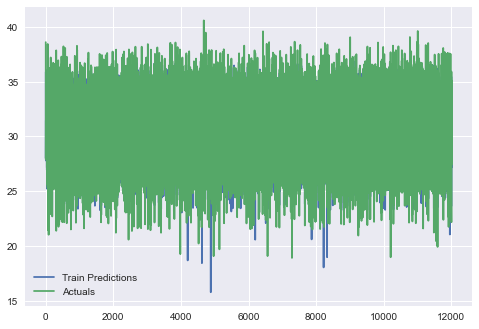

In [26]:
model = load_model('6H_Forecast/6H_ForecastModel_9_SizeWindow/')

X, y = DataHandler(6,9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])